In [48]:
from scipy import stats
import numpy as np
import pandas as pd
from sklearn import model_selection, linear_model, ensemble
import seaborn as sns


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
df = pd.read_csv('banknotes.txt', sep='\t')
df.head()

,X1,X2,X3,X4,X5,X6,real
0,214.8,131.0,131.1,9.0,9.7,141.0,1
1,214.6,129.7,129.7,8.1,9.5,141.7,1
2,214.8,129.7,129.7,8.7,9.6,142.2,1
3,214.8,129.7,129.6,7.5,10.4,142.0,1
4,215.0,129.6,129.7,10.4,7.7,141.8,1


In [3]:
#Разбиваем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df.drop('real', axis=1), df['real'], test_size=0.25, random_state=1)

In [53]:
#Создаем и обучаем модели 
lnr_123 = linear_model.LogisticRegression(solver='liblinear', random_state=1).fit(X_train.loc[:,['X1', 'X2', 'X3']], y_train)

lnr_456 = linear_model.LogisticRegression(solver='liblinear', random_state=1).fit(X_train.loc[:,['X4', 'X5', 'X6']], y_train)

lnr = linear_model.LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [31]:
#Проверяем метрику на тестовой выборке
lnr_123.score(X_test.loc[:,['X1', 'X2', 'X3']], y_test)

0.8

In [32]:
#Проверяем метрику на тестовой выборке
lnr_456.score(X_test.loc[:,['X4', 'X5', 'X6']], y_test)

0.98

In [33]:
#Проверяем метрику на тестовой выборке
lnr.score(X_test, y_test)

0.98

In [54]:
#Расчитаем для каждой модели модули отклонений от истинных цен
lnr_123_predict = abs(lnr_123.predict(X_test.loc[:,['X1', 'X2', 'X3']]) - y_test)
lnr_456_predict = abs(lnr_456.predict(X_test.loc[:,['X4', 'X5', 'X6']]) - y_test)
'''
Посмотрим на Т-тест для взаимносвязанных величин, если р < alpha,
то гипотеза о том, что распределения имеют одинаковые параметры будет отвергнута
'''

stats.ttest_rel(lnr_123_predict, lnr_456_predict)

Ttest_relResult(statistic=2.909069708199543, pvalue=0.005436282239523238)

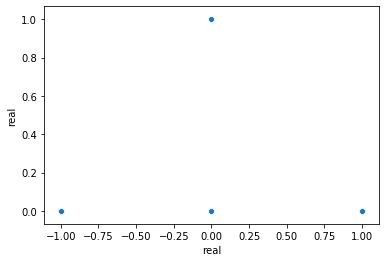

In [12]:
ax = sns.scatterplot(lnr_123_predict, lnr_456_predict)


In [38]:
from statsmodels.stats.weightstats import *
print(zconfint(lnr_123_predict))
print(zconfint(lnr_456_predict))

(0.08800205802628262, 0.3119979419737174)
(-0.019199279690801072, 0.05919927969080108)


In [39]:
stats.ttest_ind(lnr_123_predict, lnr_456_predict, equal_var = False)

Ttest_indResult(statistic=2.9731538225529546, pvalue=0.004219873820041721)

In [40]:
cm = CompareMeans(DescrStatsW(lnr_123_predict), DescrStatsW(lnr_456_predict))
print(cm.tconfint_diff())

(0.059856824397304664, 0.3001431756026954)


In [42]:
DescrStatsW(lnr_123_predict - lnr_456_predict).tconfint_mean()

(0.06970662950654867, 0.29029337049345133)

In [49]:
def proportions_diff_confint_rel(sample1, sample2, alpha = 0.05):
    z = stats.norm.ppf(1 - alpha / 2.)
    sample = list(zip(sample1, sample2))
    n = len(sample)
        
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    left_boundary = float(f - g) / n  - z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    right_boundary = float(f - g) / n  + z * np.sqrt(float((f + g)) / n**2 - float((f - g)**2) / n**3)
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_rel(sample1, sample2):
    sample = list(zip(sample1, sample2))
    n = len(sample)
    
    f = sum([1 if (x[0] == 1 and x[1] == 0) else 0 for x in sample])
    g = sum([1 if (x[0] == 0 and x[1] == 1) else 0 for x in sample])
    
    return float(f - g) / np.sqrt(f + g - float((f - g)**2) / n )

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [55]:
print("95%% confidence interval for a difference between proportions: [%.4f, %.4f]" \
      % proportions_diff_confint_rel(lnr_123_predict, lnr_456_predict))

95% confidence interval for a difference between proportions: [0.0599, 0.3001]
